In [1]:
# import library
import numpy as np 
import pandas as pd
import re
import os
import nltk 
import string
import re

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [2]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [3]:
# open dataset,save on dataframe
df = pd.read_csv("dataset/dataset_manual.csv",encoding="ISO-8859-1")
    
df.head()

,created_at,screen_name,text,label
0,5/1/2021 16:48,theoholan,itu konflik rebutan tanah,0
1,5/3/2021 14:12,KoloElang,Bisa tidak? Palestina taat secara kaffah dala...,0
2,5/5/2021 10:27,ambiszen,kalau palestina rohingya lebih ke konflik poli...,1
3,5/5/2021 10:54,NephiLaxmus,Teroris 'islam' Itu gejala baru terutama seba...,1
4,5/5/2021 19:57,Atheo8ID,@mataglo @Sentjoko paling sedikit gregetan gu...,2


In [4]:
# drop column created_at and screen_name
df = df.drop(['created_at', 'screen_name'], axis=1)

In [5]:
df

,text,label
0,itu konflik rebutan tanah,0
1,Bisa tidak? Palestina taat secara kaffah dala...,0
2,kalau palestina rohingya lebih ke konflik poli...,1
3,Teroris 'islam' Itu gejala baru terutama seba...,1
4,@mataglo @Sentjoko paling sedikit gregetan gu...,2
...,...,...
1417,Konflik Israel-Palestina urusan mereka ngapai...,1
1418,Konflik antara Israel-Palestina ini jelas buk...,1
1419,Targetkan Gencatan Senjata Permanen,1
1420,@AREAJULID bukan masalah gak support palestin...,1


In [6]:
#remove user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt   
df['remove_user'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")

In [7]:
df

,text,label,remove_user
0,itu konflik rebutan tanah,0,itu konflik rebutan tanah
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...
2,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...
3,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...
4,@mataglo @Sentjoko paling sedikit gregetan gu...,2,paling sedikit gregetan gue turun karena ka...
...,...,...,...
1417,Konflik Israel-Palestina urusan mereka ngapai...,1,Konflik Israel-Palestina urusan mereka ngapai...
1418,Konflik antara Israel-Palestina ini jelas buk...,1,Konflik antara Israel-Palestina ini jelas buk...
1419,Targetkan Gencatan Senjata Permanen,1,Targetkan Gencatan Senjata Permanen
1420,@AREAJULID bukan masalah gak support palestin...,1,bukan masalah gak support palestine atau bag...


In [8]:
def remove(tweet):
    #remove angka
    tweet = re.sub('[0-9]+', '', tweet)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    return tweet
df['remove_http'] = df['remove_user'].apply(lambda x: remove(x))

In [9]:
df.head(10)

,text,label,remove_user,remove_http
0,itu konflik rebutan tanah,0,itu konflik rebutan tanah,itu konflik rebutan tanah
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...,Bisa tidak? Palestina taat secara kaffah dala...
2,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...,kalau palestina rohingya lebih ke konflik poli...
3,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...,Teroris 'islam' Itu gejala baru terutama seba...
4,@mataglo @Sentjoko paling sedikit gregetan gu...,2,paling sedikit gregetan gue turun karena ka...,paling sedikit gregetan gue turun karena ka...
5,Tolong negara negara arab atau lainnya harus ...,1,Tolong negara negara arab atau lainnya harus ...,Tolong negara negara arab atau lainnya harus ...
6,Apa kalian yang teriak toleransi tau bagaiman...,0,Apa kalian yang teriak toleransi tau bagaiman...,Apa kalian yang teriak toleransi tau bagaiman...
7,@Sk8rwannabe memang. konflik israel-palestina...,1,memang. konflik israel-palestina memang komp...,memang. konflik israel-palestina memang komp...
8,Semoga Allah menolong saudara kita di Palesti...,0,Semoga Allah menolong saudara kita di Palesti...,Semoga Allah menolong saudara kita di Palesti...
9,Penjajahan Palestina terjadi setelah runtuhny...,2,Penjajahan Palestina terjadi setelah runtuhny...,Penjajahan Palestina terjadi setelah runtuhny...


In [10]:
#import stopword
from nltk.corpus import stopwords 
#stopwords_indonesia = stopwords.words('indonesian')
# Create Stopword
with open("Stopword.txt", "r") as f:
    stopwords_indonesia = f.readline().split()
 
#import sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#tokenize
from nltk.tokenize import TweetTokenizer
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

additional_char = set([
    'nTTTTT', 'T\n', '&amp',
    'n1','n2','n3','n4','n5', 'n6', 'n7', 'n8', 'n9',
    'x8', 'x80', 'x81', 'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x8a', 'x8b', 'x8c', 'x8d', 'x8e', 'x8f',
    'x9', 'x90', 'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x9c', 'x9d', 'x9e', 'x9f',
    'xa', 'xa0', 'xa1', 'xa2', 'xa3', 'xa4', 'xa5', 'xa6', 'xa7', 'xa8', 'xa9', 'xaa', 'xac', 'xad', 'xae',
    'xb', 'xb0', 'xb1', 'xb2', 'xb3', 'xb4', 'xb5', 'xb6', 'xb7', 'xb8', 'xb9', 'xba', 'xab', 'xbb', 'xbc', 'xbd',
    'xc', 'xc1', 'xc2', 'xe2', 'xef', 'xf', 'xf0' 
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)
 
def clean_tweets(tweet):
    
    #Convert to lower case
    tweet  = tweet.lower()
    
    #Convert www.* or https?://* to ''
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1',tweet)
    
    # remove old style retweet text "RT" dan karakter yang tidak dibutuhkan
    tweet = re.sub(r"b'rt", '', tweet)
    tweet = re.sub(r"b'", '', tweet)
    tweet = re.sub(r'b"', '', tweet)
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_indonesia and # remove stopwords
              word not in emoticons and # remove emoticons
                    word not in additional_char and #remove add_char
                        word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
 
    return tweets_clean

In [11]:
df['tweet_clean'] = df['remove_http'].apply(lambda x: clean_tweets(x))

In [12]:
df

,text,label,remove_user,remove_http,tweet_clean
0,itu konflik rebutan tanah,0,itu konflik rebutan tanah,itu konflik rebutan tanah,"[itu, konflik, rebut, tanah]"
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...,Bisa tidak? Palestina taat secara kaffah dala...,"[bisa, tidak, palestina, taat, cara, kaffah, d..."
2,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...,kalau palestina rohingya lebih ke konflik poli...,"[kalau, palestina, rohingya, lebih, ke, konfli..."
3,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...,Teroris 'islam' Itu gejala baru terutama seba...,"[teroris, islam, itu, gejala, baru, utama, bag..."
4,@mataglo @Sentjoko paling sedikit gregetan gu...,2,paling sedikit gregetan gue turun karena ka...,paling sedikit gregetan gue turun karena ka...,"[paling, sedikit, gregetan, gue, turun, karena..."
...,...,...,...,...,...
1417,Konflik Israel-Palestina urusan mereka ngapai...,1,Konflik Israel-Palestina urusan mereka ngapai...,Konflik Israel-Palestina urusan mereka ngapai...,"[konflik, israel-palestina, urus, mereka, ngap..."
1418,Konflik antara Israel-Palestina ini jelas buk...,1,Konflik antara Israel-Palestina ini jelas buk...,Konflik antara Israel-Palestina ini jelas buk...,"[konflik, antara, israel-palestina, ini, jelas..."
1419,Targetkan Gencatan Senjata Permanen,1,Targetkan Gencatan Senjata Permanen,Targetkan Gencatan Senjata Permanen,"[target, gencat, senjata, permanen]"
1420,@AREAJULID bukan masalah gak support palestin...,1,bukan masalah gak support palestine atau bag...,bukan masalah gak support palestine atau bag...,"[bukan, masalah, gak, support, palestine, atau..."


In [13]:
def remove_punct(text):
    text  = " ".join([char for char in text if char not in string.punctuation])
    return text

In [14]:
df['Tweet'] = df['tweet_clean'].apply(lambda x: remove_punct(x))

In [15]:
df

,text,label,remove_user,remove_http,tweet_clean,Tweet
0,itu konflik rebutan tanah,0,itu konflik rebutan tanah,itu konflik rebutan tanah,"[itu, konflik, rebut, tanah]",itu konflik rebut tanah
1,Bisa tidak? Palestina taat secara kaffah dala...,0,Bisa tidak? Palestina taat secara kaffah dala...,Bisa tidak? Palestina taat secara kaffah dala...,"[bisa, tidak, palestina, taat, cara, kaffah, d...",bisa tidak palestina taat cara kaffah dalam is...
2,kalau palestina rohingya lebih ke konflik poli...,1,kalau palestina rohingya lebih ke konflik poli...,kalau palestina rohingya lebih ke konflik poli...,"[kalau, palestina, rohingya, lebih, ke, konfli...",kalau palestina rohingya lebih ke konflik poli...
3,Teroris 'islam' Itu gejala baru terutama seba...,1,Teroris 'islam' Itu gejala baru terutama seba...,Teroris 'islam' Itu gejala baru terutama seba...,"[teroris, islam, itu, gejala, baru, utama, bag...",teroris islam itu gejala baru utama bagai imba...
4,@mataglo @Sentjoko paling sedikit gregetan gu...,2,paling sedikit gregetan gue turun karena ka...,paling sedikit gregetan gue turun karena ka...,"[paling, sedikit, gregetan, gue, turun, karena...",paling sedikit gregetan gue turun karena kamu ...
...,...,...,...,...,...,...
1417,Konflik Israel-Palestina urusan mereka ngapai...,1,Konflik Israel-Palestina urusan mereka ngapai...,Konflik Israel-Palestina urusan mereka ngapai...,"[konflik, israel-palestina, urus, mereka, ngap...",konflik israel-palestina urus mereka ngapain k...
1418,Konflik antara Israel-Palestina ini jelas buk...,1,Konflik antara Israel-Palestina ini jelas buk...,Konflik antara Israel-Palestina ini jelas buk...,"[konflik, antara, israel-palestina, ini, jelas...",konflik antara israel-palestina ini jelas buka...
1419,Targetkan Gencatan Senjata Permanen,1,Targetkan Gencatan Senjata Permanen,Targetkan Gencatan Senjata Permanen,"[target, gencat, senjata, permanen]",target gencat senjata permanen
1420,@AREAJULID bukan masalah gak support palestin...,1,bukan masalah gak support palestine atau bag...,bukan masalah gak support palestine atau bag...,"[bukan, masalah, gak, support, palestine, atau...",bukan masalah gak support palestine atau bagai...


In [16]:
df.drop(df.columns[[0,2,3,4]], axis = 1, inplace = True)

In [17]:
# delete missing value 
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df.dropna(subset=['Tweet'], inplace=True)

In [18]:
df.head(5)

,label,Tweet
0,0,itu konflik rebut tanah
1,0,bisa tidak palestina taat cara kaffah dalam is...
2,1,kalau palestina rohingya lebih ke konflik poli...
3,1,teroris islam itu gejala baru utama bagai imba...
4,2,paling sedikit gregetan gue turun karena kamu ...


1    694
0    374
2    354
Name: label, dtype: int64


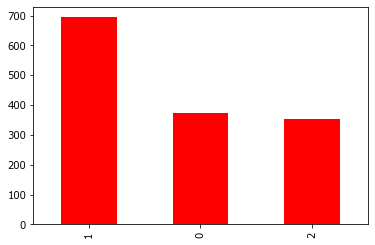

In [19]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [20]:
# convert to CSV
df.to_csv('clean.csv', encoding='utf-8', index=False)

In [21]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.Tweet)
sequences = tokenizer.texts_to_sequences(df.Tweet)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [22]:
print('Found %d unique words.' % len(word_index))

Found 3245 unique words.


In [23]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [24]:
# Prepare to y as label
y = df["label"]
y = to_categorical(y)

In [25]:
classes = ['0', '1', '2']

In [26]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [27]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [28]:
test = embeddings_index.get("netizen")
test

array([-4.327230e-01, -3.119420e-01,  1.094491e+00, -2.145950e-01,
        7.534390e-01,  1.659070e+00,  4.936180e-01,  1.409000e-03,
        4.884600e-01,  2.542550e-01, -4.979390e-01,  5.617340e-01,
        7.850000e-04,  4.132720e-01, -1.368150e-01, -9.046870e-01,
        1.362670e-01,  4.538210e-01, -5.378070e-01, -3.954030e-01,
        4.325460e-01,  1.985550e-01,  9.402100e-01,  7.971500e-01,
       -3.500120e-01, -1.429267e+00, -2.684250e-01,  1.794200e-02,
       -5.229970e-01, -3.316800e-02, -6.168300e-02, -3.128350e-01,
        6.554350e-01,  6.181870e-01, -6.873700e-01, -4.817520e-01,
       -3.157320e-01,  5.082510e-01, -7.406850e-01,  3.074100e-01,
       -1.201028e+00, -1.213599e+00,  1.140920e-01,  3.905700e-02,
        6.468660e-01, -1.947500e-02, -4.191220e-01, -5.519950e-01,
        6.553630e-01,  4.248600e-01], dtype=float32)

In [29]:
# jumlah kata yg miss tidak ada dalam vector glove
misses

397

In [30]:
# kata-kataa yang tidak berhasil di bobot
index

['gencat',
 'kadrun',
 'nyerang',
 'freepalestine',
 'israelterrorist',
 'laknatullah',
 'koar',
 'savepalestine',
 'd',
 'westandwithpalestine',
 'covid',
 'libat',
 'urusin',
 'wkwk',
 'israelterrorists',
 'drun',
 'worldstandswithpalestine',
 'pengetahuanan',
 'pedulimasjidalaqsa',
 'umatislambersatu',
 'muslimjogjabergerak',
 'tentangkemanusiaan',
 'cmiiw',
 'ngerasa',
 'palestineunderattack',
 'i',
 'bayangin',
 'laknatulloh',
 'freepalastine',
 'simpat',
 'u',
 'karenaa',
 'israelterrorism',
 'n',
 'segitunya',
 'ngaruh',
 'salahin',
 'komenannya',
 'ngerebut',
 'alaqsa',
 'savesheikhjarrah',
 'alaqsaunderattack',
 'ngelawan',
 'blablabla',
 's',
 'ahistoris',
 'hahahaa',
 'abuti',
 'tweetnya',
 'ngedoain',
 'jelasin',
 'gatau',
 'gimic',
 'ngebacot',
 'a',
 'inastandswithpalestine',
 'memframing',
 'heargaza',
 'jahudi',
 'nyusahin',
 'gausah',
 'aqsacallsarmies',
 'israelpenjajah',
 'israelstopplayingvictim',
 'worldstandwithpalestine',
 'ahmadiyahbersamapalestina',
 'acau',
 '

In [31]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [32]:
# Create Model CNN
# model 2
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#     model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(GlobalMaxPooling1D())
#     model.add(Flatten())
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [33]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            162300    
                                                                 
 conv1d (Conv1D)             (None, 50, 128)           19328     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 128)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 25, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 64)            24640     
                                                        

In [34]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20, stratify=y)

In [35]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
40/40 [==============================] - 3s 33ms/step - loss: 1.3311 - accuracy: 0.4152 - val_loss: 1.0706 - val_accuracy: 0.4755
Epoch 2/40
40/40 [==============================] - 1s 22ms/step - loss: 1.0365 - accuracy: 0.4691 - val_loss: 1.0601 - val_accuracy: 0.5035
Epoch 3/40
40/40 [==============================] - 1s 22ms/step - loss: 1.0192 - accuracy: 0.4941 - val_loss: 1.0615 - val_accuracy: 0.5455
Epoch 4/40
40/40 [==============================] - 1s 22ms/step - loss: 1.0227 - accuracy: 0.4949 - val_loss: 1.0485 - val_accuracy: 0.5315
Epoch 5/40
40/40 [==============================] - 1s 21ms/step - loss: 0.9893 - accuracy: 0.5051 - val_loss: 1.0531 - val_accuracy: 0.4965
Epoch 6/40
40/40 [==============================] - 1s 21ms/step - loss: 0.9923 - accuracy: 0.5176 - val_loss: 1.0575 - val_accuracy: 0.5175
Epoch 7/40
40/40 [==============================] - 1s 21ms/step - loss: 0.9704 - accuracy: 0.5317 - val_loss: 1.0062 - val_accuracy: 0.5315
Epoch 8/40
40

CNN Accuracy: 0.5524475524475524


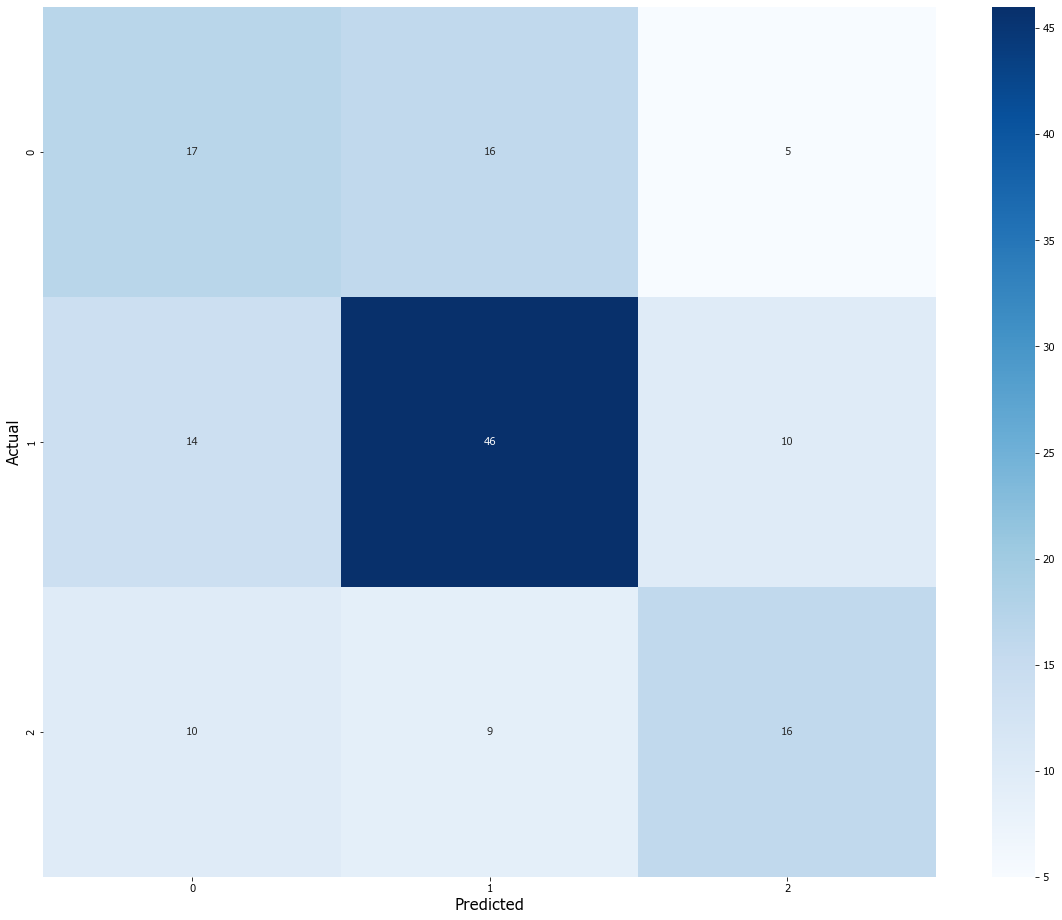

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), ypred.argmax(axis=-1),target_names= classes))

              precision    recall  f1-score   support

           0       0.41      0.45      0.43        38
           1       0.65      0.66      0.65        70
           2       0.52      0.46      0.48        35

    accuracy                           0.55       143
   macro avg       0.53      0.52      0.52       143
weighted avg       0.55      0.55      0.55       143



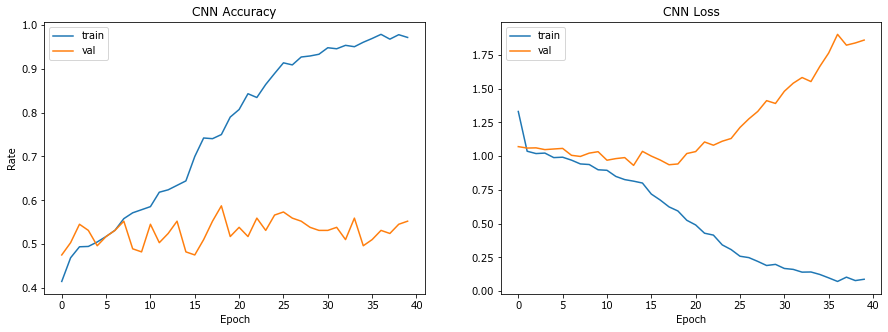

In [39]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()